This block loads all the key libraries needed for building and training a neural network on image data. It includes PyTorch for deep learning, torchvision for handling image datasets and transforms, and matplotlib for plotting. The last line checks if a GPU is available—if yes, it’ll use it for faster training; if not, it falls back to the CPU.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from collections import OrderedDict

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

This block sets up data preprocessing and loading for the CIFAR-10 dataset. For training data, it applies data augmentation like random cropping, flipping, slight rotation, and color adjustments to help the model generalize better. Both training and test images are then converted to tensors and normalized using CIFAR-10’s mean and standard deviation. Finally, it downloads the dataset (if not already present) and prepares it to be loaded in batches for training and testing.

In [2]:
# ==================== Data Augmentation ====================
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # Reduced from 15° for stability
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Loading datasets
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=128, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


This block randomly picks 10 images from the training set and displays them with their class labels. It starts by defining the class names for CIFAR-10, grabs a batch of training images, and randomly selects 10 of them. Since the images were normalized earlier, it denormalizes them for proper visualization. Finally, it plots the images in a 2x5 grid using matplotlib, showing a quick preview of what the training data looks like.

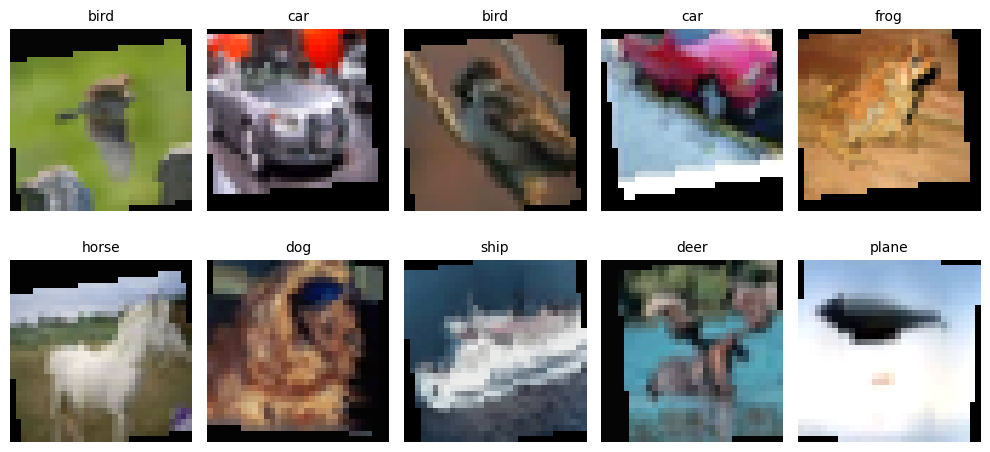

In [3]:
import numpy as np

# Define CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# ==================== Sample Image Visualization ====================
dataiter = iter(train_loader)
images, labels = next(dataiter)

indices = np.random.choice(range(len(images)), size=10, replace=False)
images = images[indices]
labels = labels[indices]

# Denormalize the images
images = images * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
images = torch.clamp(images, 0, 1)

# Plotting sample training images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    npimg = images[i].permute(1, 2, 0).numpy()
    ax.imshow(npimg)
    ax.set_title(classes[labels[i]], fontsize=10)
    ax.axis('off')
plt.tight_layout()
plt.show()


This block defines three custom neural network components to enhance model performance and regularization. `SEBlock` (Squeeze-and-Excitation) adaptively recalibrates channel-wise features by learning which channels are more important. `ConvBlock` is a hybrid convolutional block that includes multiple convolutional layers and dynamically learns to weigh their outputs based on the input, followed by batch normalization, ReLU activation, and an SEBlock for added focus. `StochasticDepth` randomly drops entire layers during training (with a set probability) to prevent overfitting and improve generalization. Together, these components form the building blocks of a more expressive and resilient CNN.

In [4]:
# ==================== Model Components ====================
class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block (from first implementation)."""
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid())

    def forward(self, x):
        b, c, _, _ = x.shape
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs=4):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            for _ in range(num_convs)
        ])
        self.attention = nn.Linear(in_channels, num_convs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels)

    def forward(self, x):
        # Dynamic convolution weighting
        channel_means = x.mean(dim=[2, 3])
        weights = F.softmax(self.attention(channel_means), dim=1)
        conv_outputs = torch.stack([conv(x) for conv in self.convs], dim=1)
        x = torch.sum(weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) * conv_outputs, dim=1)

        # Post-processing
        x = self.bn(x)
        x = F.relu(x)
        x = self.se(x)
        return x

class StochasticDepth(nn.Module):
    def __init__(self, drop_prob):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if not self.training or self.drop_prob == 0.0:
            return x
        keep_prob = 1 - self.drop_prob
        mask = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < keep_prob
        return x * mask / keep_prob

This block defines the full CNN architecture for classifying CIFAR-10 images. The `CIFARNet` model stacks several `ConvBlock` layers grouped into stages, each followed by max pooling and optional stochastic depth for regularization. The feature extractor progressively increases the number of channels to capture more complex patterns. After feature extraction, the `classifier` reduces the spatial dimensions using global average pooling, flattens the output, and passes it through two fully connected layers (with ReLU and dropout in between) to produce predictions for the 10 CIFAR-10 classes.

In [5]:
# ==================== Full Model ====================
class CIFARNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(OrderedDict([
            ("stage1_block1", ConvBlock(3, 64)),
            ("stage1_block2", ConvBlock(64, 64)),
            ("stage1_pool", nn.MaxPool2d(2, 2)),
            ("stage1_sd", StochasticDepth(0.1)),

            ("stage2_block1", ConvBlock(64, 128)),
            ("stage2_block2", ConvBlock(128, 128)),
            ("stage2_pool", nn.MaxPool2d(2, 2)),
            ("stage2_sd", StochasticDepth(0.1)),

            ("stage3_block1", ConvBlock(128, 256)),
            ("stage3_block2", ConvBlock(256, 256)),]))

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10))

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


This section sets up and runs the training process. It initializes the model, a smoothed cross-entropy loss function, and the AdamW optimizer with weight decay to help generalization. A learning rate scheduler (`OneCycleLR`) is used to adjust the learning rate dynamically during training for better convergence. The `train_model` function handles the training loop, updating weights, tracking loss, and evaluating performance after each epoch. Accuracy on both training and test sets is printed for every epoch, and the best test accuracy is reported at the end.

In [6]:
# ==================== Training Setup ====================
model = CIFARNet().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=80)

# ==================== Training Loop ====================
batch_losses = []  # Track batch-wise training loss

def train_model():
    train_accs, test_accs = [], []
    for epoch in range(65):
        model.train()
        running_loss = 0.0  # <-- Add this here
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()
            batch_losses.append(loss.item())  # Record batch loss

        # Evaluate
        model.eval()
        train_acc = evaluate(model, train_loader)
        test_acc = evaluate(model, test_loader)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f}")

    return train_accs, test_accs

def evaluate(model, loader):
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

# Run training
train_accs, test_accs = train_model()
print(f"Best Test Accuracy: {max(test_accs):.4f}")

Epoch 1: Train Acc=0.4696, Test Acc=0.4856
Epoch 2: Train Acc=0.5920, Test Acc=0.6036
Epoch 3: Train Acc=0.5859, Test Acc=0.6003
Epoch 4: Train Acc=0.6024, Test Acc=0.6268
Epoch 5: Train Acc=0.6665, Test Acc=0.6695
Epoch 6: Train Acc=0.7249, Test Acc=0.7434
Epoch 7: Train Acc=0.7085, Test Acc=0.7267
Epoch 8: Train Acc=0.7552, Test Acc=0.7787
Epoch 9: Train Acc=0.7433, Test Acc=0.7618
Epoch 10: Train Acc=0.7518, Test Acc=0.7869
Epoch 11: Train Acc=0.8001, Test Acc=0.8163
Epoch 12: Train Acc=0.7742, Test Acc=0.7813
Epoch 13: Train Acc=0.8122, Test Acc=0.8185
Epoch 14: Train Acc=0.7671, Test Acc=0.8008
Epoch 15: Train Acc=0.7954, Test Acc=0.8052
Epoch 16: Train Acc=0.8011, Test Acc=0.8019
Epoch 17: Train Acc=0.7817, Test Acc=0.7869
Epoch 18: Train Acc=0.8210, Test Acc=0.8274
Epoch 19: Train Acc=0.8392, Test Acc=0.8248
Epoch 20: Train Acc=0.8328, Test Acc=0.8326
Epoch 21: Train Acc=0.8482, Test Acc=0.8508
Epoch 22: Train Acc=0.7714, Test Acc=0.7936
Epoch 23: Train Acc=0.8551, Test Acc=0.84

This part visualizes the model's performance. It plots three graphs: the first shows how training and test accuracy change over epochs, the second displays the loss per training batch to track learning progression, and the third again shows accuracy trends but with clearer labeling and grid for better readability. These plots help understand how well the model is learning and whether it's overfitting or underfitting.

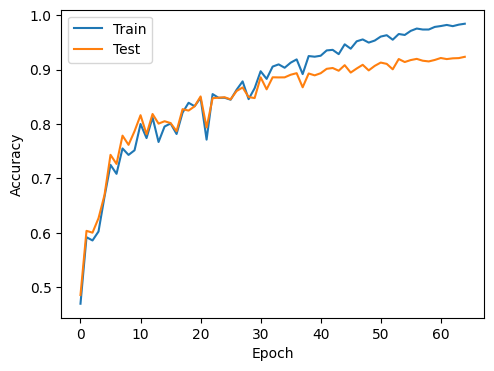

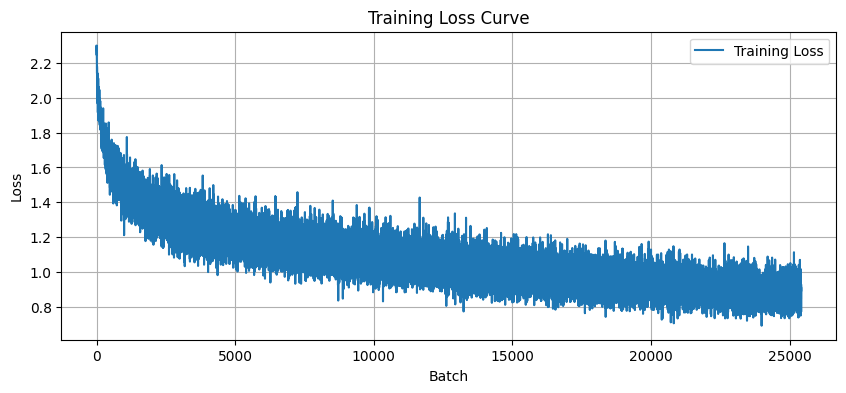

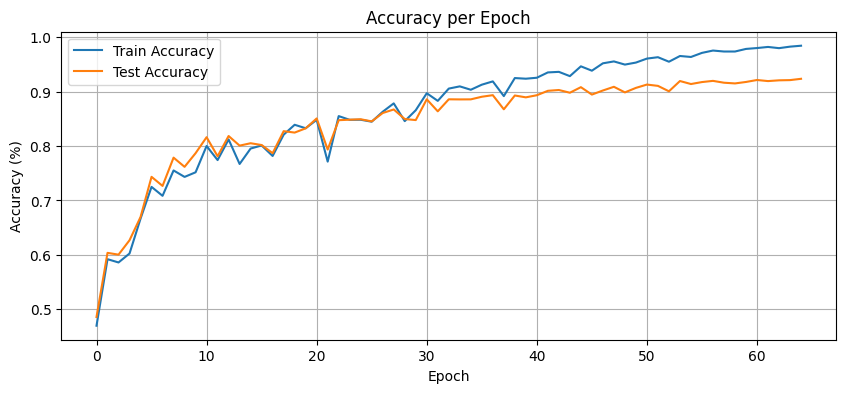

In [7]:
# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label="Train")
plt.plot(test_accs, label="Test")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(batch_losses, label='Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

This part of the code visualizes how well the model is performing by plotting a confusion matrix. It compares the true labels with the predicted ones, showing where the model is getting things right or wrong. The matrix is displayed with clear labels and color coding for easy interpretation, helping to identify any patterns of misclassification.

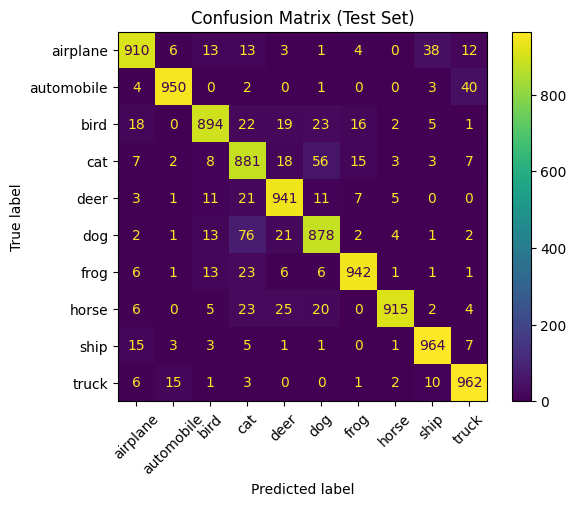

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collect predictions and true labels
all_preds, all_labels = [], []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot confusion matrix
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation=45, cmap='viridis')
plt.title("Confusion Matrix (Test Set)")
plt.show()

This part of the code selects 20 random images from the test set, makes predictions using the trained model, and then displays each image alongside its predicted and actual labels. The images are shown in a 2x10 grid, with the predicted and actual labels labeled below each image. Correct predictions are shown in blue, and incorrect predictions are shown in red. This helps visually assess how well the model is performing on individual test samples.

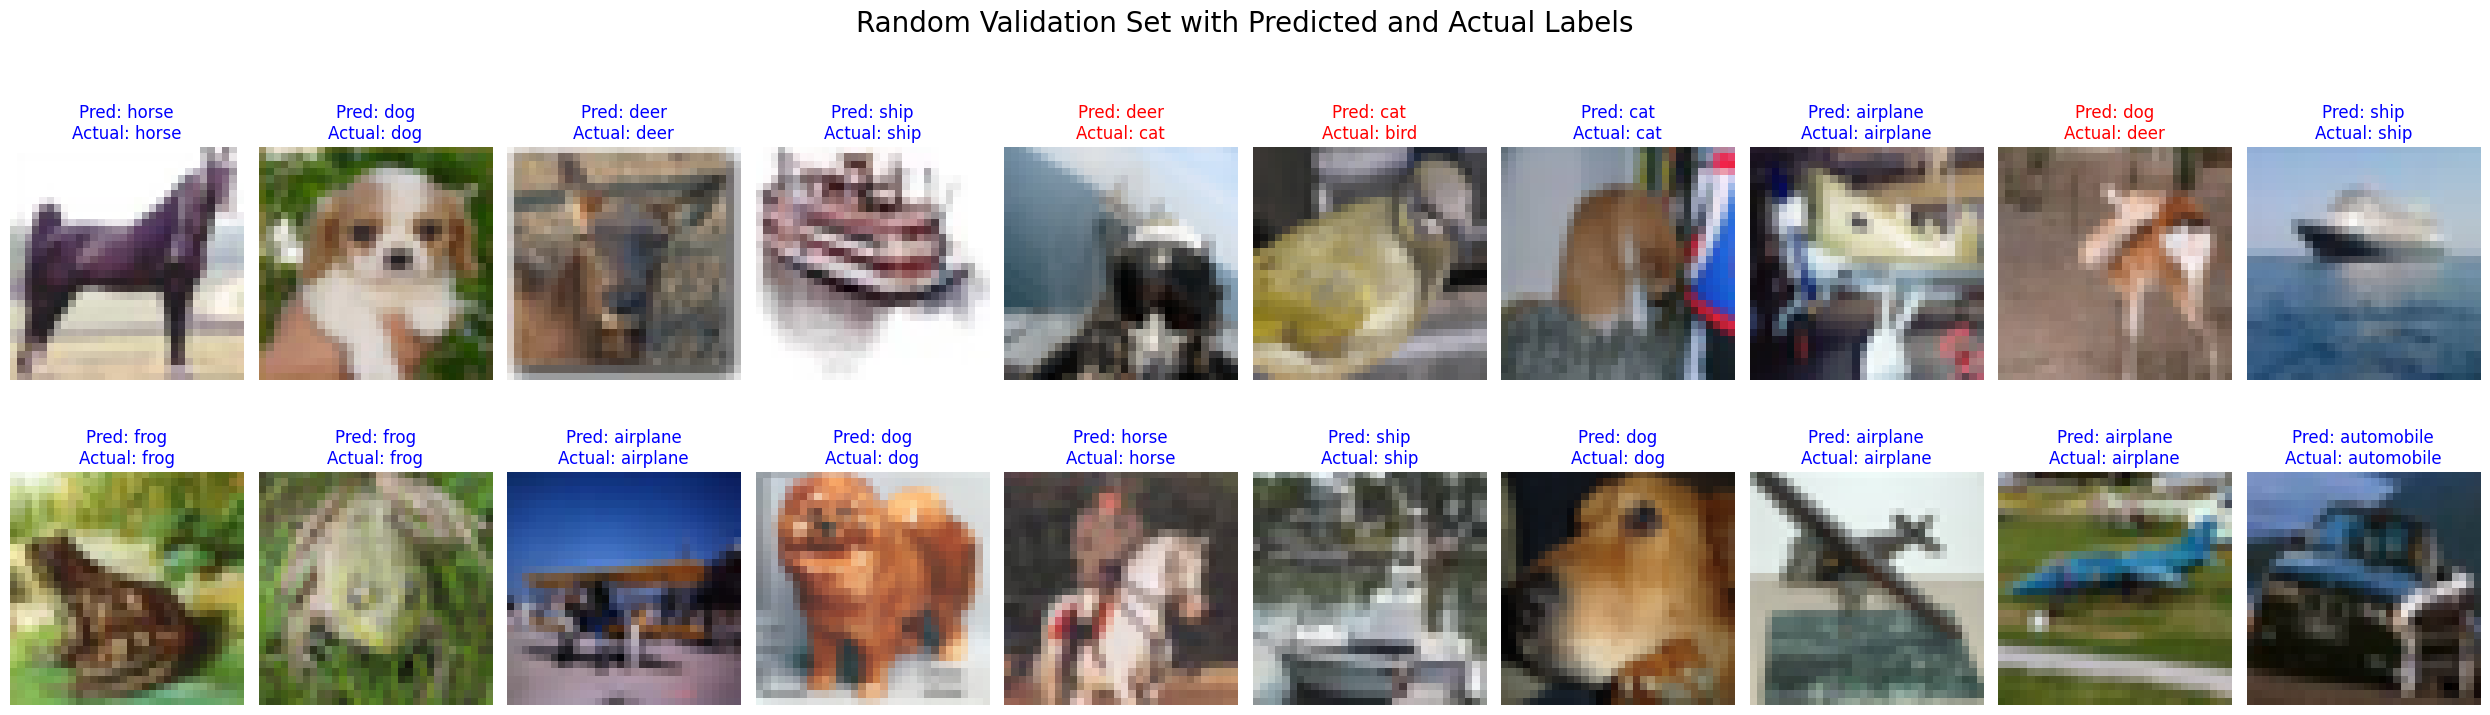

In [9]:
# ==================== Random Predictions on Test Set ====================
model.eval()
predicted_label = []
target_label = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_label.append(predicted.cpu())
        target_label.append(labels.cpu())

pred = torch.cat(predicted_label)
target = torch.cat(target_label)
indices = np.random.choice(len(target), size=20, replace=False)

# Get the test dataset images (without transformations)
testset_for_vis = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True)
subset_images = testset_for_vis.data[indices]

subset_preds = pred[indices].numpy()
subset_targets = target[indices].numpy()

# Plot predictions vs actual labels
fig, axs = plt.subplots(2, 10, figsize=(25, 8))
fig.suptitle("Random Validation Set with Predicted and Actual Labels", fontsize=20)

for i, ax in enumerate(axs.flatten()):
    ax.imshow(subset_images[i])
    ax.set_title(f"Pred: {classes[subset_preds[i]]}\nActual: {classes[subset_targets[i]]}",
                 color=("blue" if subset_preds[i] == subset_targets[i] else "red"), fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()